# Module 7: Synthetic Data Generation and RAG Evaluation with Ragas

In this notebook, we'll go end-to-end from **generating synthetic evaluation data** to **systematically evaluating and improving a RAG pipeline** — all using [Ragas](https://github.com/explodinggradients/ragas).

The flow is:
1. **Generate** synthetic test data using Ragas' knowledge graph-based approach
2. **Build** a baseline RAG application with LangChain and LangGraph
3. **Evaluate** the RAG application against our synthetic test set using Ragas metrics
4. **Iterate** on the pipeline and measure the impact

> **NOTE:** Ragas is framework-agnostic — while this example uses LangChain/LangGraph, you can use Ragas with any framework (or none at all). Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

## Outline

**Part 1: Synthetic Data Generation**
- Task 1: Dependencies and API Keys
- Task 2: Data Preparation
- Task 3: Knowledge Graph Construction
- Task 4: Generating Synthetic Test Data
- ***❓ Question #1 & Question #2***
- ***🏗️ Activity #1: Custom Query Distribution***

**Part 2: RAG Evaluation with Ragas**
- Task 5: Building a Baseline RAG Application
- Task 6: Evaluating with Ragas
- Task 7: Making Adjustments and Re-Evaluating
- ***❓ Question #3, Question #4, Question #5, & Question #6***
- ***🏗️ Activity #2: Implement a Different Reranking Strategy***

---
# Part 1: Synthetic Data Generation with Ragas

Before we can evaluate a RAG system, we need high-quality test data. Manually creating question-answer pairs is time-consuming and often biased toward simple queries. Ragas solves this by building a **knowledge graph** from your documents and using it to generate diverse, realistic test questions automatically.

We'll use the **Stone Ridge 2025 Investor Letter** and an **Alternative Investments Handbook** as our source documents — maintaining continuity with the investment advisory use case from previous sessions.

## Task 1: Dependencies and API Keys

If you have not already done so, install the required libraries using the uv package manager:
```bash
uv sync
```

We'll need API keys for:
- **OpenAI** — for LLM and embedding models (used in both SDG and RAG evaluation)
- **Cohere** — for reranking in the improved pipeline ([sign up here](https://docs.cohere.com/reference/about))

You have two options for supplying your API keys:
- Use environment variables (copy `.env.sample` to `.env` and fill in your keys)
- Provide them via the prompts below

In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     Basic Constraints of CA cert not marked critical
[nltk_data]     (_ssl.c:1028)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: Basic Constraints of CA cert not marked
[nltk_data]     critical (_ssl.c:1028)>


False

In [3]:
import os
from getpass import getpass
from dotenv import load_dotenv

load_dotenv()

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass("Please enter your OpenAI API key!")

if not os.environ.get("COHERE_API_KEY"):
    os.environ["COHERE_API_KEY"] = getpass("Please enter your Cohere API key!")

## Task 2: Data Preparation

We'll prepare our data using two complementary investment-focused sources:
- **Stone Ridge 2025 Investor Letter** — covering Stone Ridge's investment philosophy, Bayesian approach to decision-making, energy investments, reinsurance, and risk management
- **Alternative Investments Handbook** — covering alternative asset classes including real estate, private equity, hedge funds, reinsurance, commodities, and infrastructure

The topical overlap between these documents (particularly around reinsurance, risk premiums, diversification, and alternative investments) helps Ragas build rich cross-document relationships in the knowledge graph.

In [4]:
from langchain_community.document_loaders import PyMuPDFLoader, TextLoader

# Load the Stone Ridge 2025 Investor Letter (PDF)
pdf_loader = PyMuPDFLoader("data/Stone Ridge 2025 Investor Letter.pdf")
pdf_docs = pdf_loader.load()

# Load the Alternative Investments Handbook (text)
txt_loader = TextLoader("data/AlternativeInvestmentsHandbook.txt")
txt_docs = txt_loader.load()

# Combine into a single list
docs = pdf_docs + txt_docs
print(f"Loaded {len(docs)} documents:")
print(f"  - Stone Ridge 2025 Investor Letter: {len(pdf_docs)} pages")
print(f"  - AlternativeInvestmentsHandbook.txt: {len(txt_docs)} document(s)")

Loaded 15 documents:
  - Stone Ridge 2025 Investor Letter: 14 pages
  - AlternativeInvestmentsHandbook.txt: 1 document(s)


## Task 3: Knowledge Graph Construction

Ragas uses a **knowledge graph-based approach** to create synthetic test data. This is powerful because it allows us to create complex, multi-hop queries — not just simple factoid questions. Systems tend to perform well on simple evaluation tasks, so this additional complexity helps us find real weaknesses.

The process works in three stages:
1. **Build the graph** — insert documents as nodes
2. **Apply transformations** — extract headlines, summaries, themes, entities, and embeddings
3. **Create relationships** — use cosine similarity and overlap scores to connect related nodes

Let's start by defining our `generator_llm` and `generator_embeddings`.

In [5]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

/Users/alexei.naumann/Desktop/AIE/AI-Engineering/07_Synthetic_Data_and_Evaluation/.venv/lib/python3.13/site-packages/pysbd/segmenter.py:66: SyntaxWarning: invalid escape sequence '\s'
  for match in re.finditer('{0}\s*'.format(re.escape(sent)), self.original_text):
/Users/alexei.naumann/Desktop/AIE/AI-Engineering/07_Synthetic_Data_and_Evaluation/.venv/lib/python3.13/site-packages/pysbd/lang/arabic.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)
/Users/alexei.naumann/Desktop/AIE/AI-Engineering/07_Synthetic_Data_and_Evaluation/.venv/lib/python3.13/site-packages/pysbd/lang/persian.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)


### Step 1: Initialize the Knowledge Graph

We create an empty knowledge graph and populate it with our document nodes. Each full document becomes a node of type `DOCUMENT`.

In [6]:
from ragas.testset.graph import KnowledgeGraph, Node, NodeType

kg = KnowledgeGraph()

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 15, relationships: 0)

### Step 2: Apply Transformations

Now we apply the [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms) to enrich our knowledge graph. These transformations:

- **HeadlinesExtractor** — finds the overall headlines for each document
- **SummaryExtractor** — produces summaries of the documents
- **ThemesExtractor** — extracts broad themes
- **EmbeddingExtractor** — creates embeddings for similarity computation
- **NERExtractor** — extracts named entities

These are then used to build relationships between nodes via cosine similarity and overlap scoring.

In [7]:
from ragas.testset.transforms import default_transforms, apply_transforms

transforms = default_transforms(
    documents=docs,
    llm=generator_llm,
    embedding_model=generator_embeddings
)
apply_transforms(kg, transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/14 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/15 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node


Applying SummaryExtractor:   0%|          | 0/26 [00:00<?, ?it/s]

Property 'summary' already exists in node '132413'. Skipping!
Property 'summary' already exists in node 'a76a82'. Skipping!
Property 'summary' already exists in node '697b0a'. Skipping!
Property 'summary' already exists in node '44a429'. Skipping!
Property 'summary' already exists in node '35fe94'. Skipping!
Property 'summary' already exists in node '9cb6a7'. Skipping!
Property 'summary' already exists in node '146f6b'. Skipping!
Property 'summary' already exists in node '68adf1'. Skipping!
Property 'summary' already exists in node 'ac02b0'. Skipping!
Property 'summary' already exists in node '8f6ea5'. Skipping!
Property 'summary' already exists in node '6c6749'. Skipping!
Property 'summary' already exists in node 'd48a73'. Skipping!


Applying CustomNodeFilter:   0%|          | 0/8 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/42 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node '132413'. Skipping!
Property 'summary_embedding' already exists in node 'a76a82'. Skipping!
Property 'summary_embedding' already exists in node '697b0a'. Skipping!
Property 'summary_embedding' already exists in node '68adf1'. Skipping!
Property 'summary_embedding' already exists in node 'ac02b0'. Skipping!
Property 'summary_embedding' already exists in node '44a429'. Skipping!
Property 'summary_embedding' already exists in node '9cb6a7'. Skipping!
Property 'summary_embedding' already exists in node '146f6b'. Skipping!
Property 'summary_embedding' already exists in node '35fe94'. Skipping!
Property 'summary_embedding' already exists in node 'd48a73'. Skipping!
Property 'summary_embedding' already exists in node '8f6ea5'. Skipping!
Property 'summary_embedding' already exists in node '6c6749'. Skipping!


Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 35, relationships: 330)

### Step 3: Save the Knowledge Graph

Knowledge graphs can be saved and loaded, which is useful for iterating on test generation without rebuilding the graph each time.

In [8]:
kg.save("investment_data_kg.json")

# You can reload it later:
# kg = KnowledgeGraph.load("investment_data_kg.json")

## Task 4: Generating Synthetic Test Data

With our knowledge graph built, we can now generate synthetic test data. Ragas provides several **query synthesizers**, each producing a different type of question:

- **`SingleHopSpecificQuerySynthesizer`** — creates questions answerable from a single chunk of context (e.g., *"What is Stone Ridge's approach to reinsurance investing?"*)
- **`MultiHopAbstractQuerySynthesizer`** — creates questions requiring synthesis across multiple chunks at an abstract level (e.g., *"How do alternative risk premiums relate to portfolio diversification?"*)
- **`MultiHopSpecificQuerySynthesizer`** — creates questions requiring specific details from multiple chunks (e.g., *"How does Stone Ridge's Bayesian philosophy connect to their energy investment strategy?"*)

We define a **query distribution** to control the mix of question types.

In [9]:
from ragas.testset.synthesizers import (
    SingleHopSpecificQuerySynthesizer,
    MultiHopAbstractQuerySynthesizer,
    MultiHopSpecificQuerySynthesizer,
)

query_distribution = [
    (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
    (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
    (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

In [10]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(
    llm=generator_llm,
    embedding_model=generator_embeddings,
    knowledge_graph=kg
)

testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What is the date 9/30/2025?,[Standardized returns as of most recent quarte...,Standardized returns as of most recent quarter...,single_hop_specifc_query_synthesizer
1,What is Stone Ridge known for in the context o...,[Risk Disclosures This communication has been ...,The provided context does not specify what Sto...,single_hop_specifc_query_synthesizer
2,What is reinsurance?,[The Alternative Investments Handbook A Practi...,Reinsurance is included among alternative inve...,single_hop_specifc_query_synthesizer
3,What does the cap rate indicate in real estate...,[PART 2: REAL ESTATE INVESTMENTS Chapter 4: Re...,"The cap rate, or capitalization rate, is calcu...",single_hop_specifc_query_synthesizer
4,What is Series B in venture capital?,[Chapter 7: Venture Capital Venture capital (V...,Series B and beyond are later rounds for compa...,single_hop_specifc_query_synthesizer
5,How do the characteristics of infrastructure i...,[<1-hop>\n\nThe Alternative Investments Handbo...,"Infrastructure investments provide stable, pre...",multi_hop_abstract_query_synthesizer
6,Wht are the investment performnce metrics and ...,[<1-hop>\n\nStandardized returns as of most re...,"The investment performance metrics, such as th...",multi_hop_abstract_query_synthesizer
7,How does real estate contribute to portfolio d...,[<1-hop>\n\nThe Alternative Investments Handbo...,Real estate contributes to portfolio diversifi...,multi_hop_abstract_query_synthesizer
8,Considering the insights from PART 2 on real e...,[<1-hop>\n\nPART 5: INSURANCE-LINKED INVESTMEN...,Integrating catastrophe risk modeling and rein...,multi_hop_specific_query_synthesizer
9,What hedge fund strategies are discussed in th...,[<1-hop>\n\nThe Alternative Investments Handbo...,The context discusses various hedge fund strat...,multi_hop_specific_query_synthesizer


### Abstracted SDG (Shortcut)

The above was the **unrolled** process showing each step. Ragas also provides a one-liner that builds the knowledge graph under the hood and generates the test set in a single call. This is convenient for quick iteration:

In [11]:
# Abstracted approach (for reference):
# generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
# dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

##### ✅ Answer:

The query synthesizers are taking chunks of the input documents and generating questions based on the contents of the document chunks. They use an LLM to come up with questions about the chunks and also generate answers with sources cited. Having this automatically-generated question-response data set allows you to test the effectiveness of the RAG pipeline you built for retrieving answers. <br><br>
The three types of synthesizers are generating questions with differing levels of difficulty and differing quantities of documents required to be processed in answering the questions. THe single hop synthesizer tests the RAG system with questions that only require data from a single document to answer the question. The multi-hop abastract synthesizer generates abstract questions that require multiple documents and a broad understanding about how the data in those documents is related. The multi-hop specific question synthesizer generates questions that require multiple documents to answer and that also require specific details from those documents. 

### ❓ Question #2:

Ragas offers both an "unrolled" (manual) approach and an "abstracted" (automatic) approach to synthetic data generation. What are the trade-offs between these two approaches? When would you choose one over the other?

##### ✅ Answer:

You need to specify a lot more custom config properties with the manual approach, which ultimately gives you tighter control and a higher degree of customizability over how the test dataset is built. The automatic approach gives you less control in generating synthetic data but, it's easier to use and faster for one-off experiments or rapid iteration. I would use the automatic approach for early-stage RAG evaluation and rapid prototyping and then likely move to the manual approach when I want to test specific factets and connections in my RAG pipeline. 

### 🏗️ Activity #1: Custom Query Distribution

Modify the `query_distribution` to experiment with different ratios of query types.

**Requirements:**
1. Create a custom query distribution with different weights than the default
2. Generate a new test set using your custom distribution
3. Compare the types of questions generated with the default distribution
4. Explain why you chose the weights you did

In [12]:
### YOUR CODE HERE ###
modified_query_distribution = [
    # hypothetically expect to have my RAG system answering 50% simple fact retrieval questions
    (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
    # don't expect to get too many abstract questions
    (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.1),
    # have the RAG system evaluated for some specific multi-document questions
    (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.4),
]

generator = TestsetGenerator(
    llm=generator_llm,
    embedding_model=generator_embeddings,
    knowledge_graph=kg
)

testset = generator.generate(testset_size=10, query_distribution=modified_query_distribution)
testset.to_pandas()

# Define a custom query distribution with different weights
# Generate a new test set and compare with the default

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,Can you tell me how Stone Ridge Energy's stand...,[Standardized returns as of most recent quarte...,Standardized returns as of the most recent qua...,single_hop_specifc_query_synthesizer
1,Can you tell me about Stone Rigde and how it r...,[Risk Disclosures This communication has been ...,The provided context discusses Stone Ridge in ...,single_hop_specifc_query_synthesizer
2,what are commodities,[The Alternative Investments Handbook A Practi...,Commodities are included in alternative invest...,single_hop_specifc_query_synthesizer
3,What are private real estate funds?,[PART 2: REAL ESTATE INVESTMENTS Chapter 4: Re...,Private real estate funds are pooled vehicles ...,single_hop_specifc_query_synthesizer
4,Venture Capital what is it do for invest in ea...,[Chapter 7: Venture Capital Venture capital (V...,Venture capital (VC) is a specialized form of ...,single_hop_specifc_query_synthesizer
5,How does infrastructure as a long-term investm...,[<1-hop>\n\nThe Alternative Investments Handbo...,"Infrastructure, as highlighted in the Alternat...",multi_hop_abstract_query_synthesizer
6,PART 5 reinsurance part and PART 6 commodities...,[<1-hop>\n\nPART 5: INSURANCE-LINKED INVESTMEN...,"In PART 5, reinsurance is shown as an uncorrel...",multi_hop_specific_query_synthesizer
7,Hedge fund strategies and hedge fund strategie...,[<1-hop>\n\nThe Alternative Investments Handbo...,The context explains that hedge fund strategie...,multi_hop_specific_query_synthesizer
8,How do PART 2's insights on reinsurance invest...,[<1-hop>\n\nPART 5: INSURANCE-LINKED INVESTMEN...,"PART 5 explains that reinsurance investments, ...",multi_hop_specific_query_synthesizer
9,How do Chapters 2 and 5 of 'The Alternative In...,[<1-hop>\n\nThe Alternative Investments Handbo...,Chapter 2 discusses the role of alternative in...,multi_hop_specific_query_synthesizer


---
# Part 2: RAG Evaluation with Ragas

Now that we have our synthetic test data, we can use it to **systematically evaluate** a RAG pipeline. The idea is simple:
1. Build a RAG application
2. Run our synthetic queries through it
3. Score the results using Ragas metrics
4. Make changes and measure the impact

This gives us a **data-driven approach** to improving our RAG system, rather than relying on vibes.

## Task 5: Building a Baseline RAG Application

We'll build a deliberately simple (and somewhat bad) RAG pipeline as our **baseline**, so we can clearly see the impact of improvements later.

Our baseline uses:
- Tiny chunks (50 characters) with no overlap
- A small embedding model (`text-embedding-3-small`)
- Only 3 retrieved documents
- A basic prompt

> **NOTE:** We use the same data that our synthetic test set was generated from — this is required because the test questions are specifically designed for this investment data.

### R — Retrieval

First, we chunk our documents and build a vector store.

In [13]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=50, chunk_overlap=0)
split_documents = text_splitter.split_documents(docs)
len(split_documents)

2045

### ❓ Question #3:

What is the purpose of the `chunk_overlap` parameter in the `RecursiveCharacterTextSplitter`?

##### ✅ Answer:

It allows you to adjust thoughts and facts in the input documents that may span multiple chunks. This could happen if a contextual fact is long or takes multiple sentences to elucidate. The higher the chunk overlap, the less chance there is of missing one of these complex thoughts that may span multiple input text chunks.

In [14]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [15]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="baseline_rag",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="baseline_rag",
    embedding=embeddings,
)

_ = vector_store.add_documents(documents=split_documents)

In [16]:
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [17]:
def retrieve(state):
    retrieved_docs = retriever.invoke(state["question"])
    return {"context": retrieved_docs}

### A — Augmented

A simple RAG prompt:

In [18]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """\
You are a helpful investment advisory assistant who answers questions based on provided context. You must only use the provided context, and cannot use your own knowledge.

### Question
{question}

### Context
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

### G — Generation

We use `gpt-4.1-nano` for generation to avoid using the same model as our judge model.

In [19]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-nano")

In [20]:
def generate(state):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
    response = llm.invoke(messages)
    return {"response": response.content}

### Building the RAG Graph with LangGraph

In [21]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class State(TypedDict):
    question: str
    context: List[Document]
    response: str

In [22]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

Let's do a quick sanity check:

In [23]:
response = graph.invoke({"question": "What is Stone Ridge's investment philosophy?"})
response["response"]

"The provided context does not include specific information about Stone Ridge's investment philosophy."

With tiny 50-character chunks and only 3 retrieved documents, the baseline likely struggles to provide good answers about Stone Ridge's investment philosophy. That's intentional — it gives us room to improve!

## Task 6: Evaluating with Ragas

Now we can evaluate our baseline RAG against the synthetic test data we generated in Part 1.

First, we run all the synthetic queries through our RAG pipeline to collect responses and retrieved contexts.

In [24]:
for test_row in testset:
    response = graph.invoke({"question": test_row.eval_sample.user_input})
    test_row.eval_sample.response = response["response"]
    test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

Convert to an `EvaluationDataset` for smoother evaluation:

In [25]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(testset.to_pandas())

We select a **judge model** — a separate, capable model that scores the outputs. Using a different model than the generator avoids self-evaluation bias.

In [26]:
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))

### Running the Baseline Evaluation

We evaluate across six metrics:
- **Context Recall** — did we retrieve the relevant context?
- **Faithfulness** — is the answer grounded in the retrieved context?
- **Factual Correctness** — is the answer factually correct vs. the reference?
- **Answer Relevancy** — is the answer relevant to the question?
- **Context Entity Recall** — did we capture the key entities from the reference context?
- **Noise Sensitivity** — is the answer affected by irrelevant retrieved content?

In [27]:
from ragas.metrics import (
    LLMContextRecall,
    Faithfulness,
    FactualCorrectness,
    ResponseRelevancy,
    ContextEntityRecall,
    NoiseSensitivity,
)
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

baseline_result = evaluate(
    dataset=evaluation_dataset,
    metrics=[
        LLMContextRecall(),
        Faithfulness(),
        FactualCorrectness(),
        ResponseRelevancy(),
        ContextEntityRecall(),
        NoiseSensitivity(),
    ],
    llm=evaluator_llm,
    run_config=custom_run_config,
)
baseline_result

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[8]: AttributeError('StringIO' object has no attribute 'statements')


{'context_recall': 0.0833, 'faithfulness': 0.4631, 'factual_correctness': 0.3767, 'answer_relevancy': 0.5616, 'context_entity_recall': 0.2324, 'noise_sensitivity_relevant': 0.0234}

## Task 7: Making Adjustments and Re-Evaluating

Now that we have a baseline, let's improve the pipeline and measure the impact. We'll make three changes:

1. **Larger chunks** (500 characters with 30 overlap instead of 50 with 0 overlap)
2. **More documents retrieved** (k=20 instead of k=3)
3. **Reranking with Cohere** — retrieves 20 documents, then uses Cohere's reranker to select the top 5

Reranking is a technique that uses a cross-encoder model (slower but more accurate than embedding similarity) on a smaller subset of candidates to improve retrieval precision.

In [28]:
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=30)
split_documents = text_splitter.split_documents(docs)
print(f"Improved chunking: {len(split_documents)} chunks (vs baseline)")

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

client = QdrantClient(":memory:")
client.create_collection(
    collection_name="improved_rag",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="improved_rag",
    embedding=embeddings,
)

_ = vector_store.add_documents(documents=split_documents)
adjusted_retriever = vector_store.as_retriever(search_kwargs={"k": 20})

Improved chunking: 202 chunks (vs baseline)


In [29]:
from langchain_classic.retrievers.contextual_compression import (
    ContextualCompressionRetriever,
)
from langchain_cohere import CohereRerank

def retrieve_adjusted(state):
    compressor = CohereRerank(model="rerank-v3.5")
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=compressor,
        base_retriever=adjusted_retriever,
        search_kwargs={"k": 5},
    )
    retrieved_docs = compression_retriever.invoke(state["question"])
    return {"context": retrieved_docs}

In [30]:
from typing import TypedDict, List
from langchain_core.documents import Document

class AdjustedState(TypedDict):
    question: str
    context: List[Document]
    response: str

adjusted_graph_builder = StateGraph(AdjustedState).add_sequence([retrieve_adjusted, generate])
adjusted_graph_builder.add_edge(START, "retrieve_adjusted")
adjusted_graph = adjusted_graph_builder.compile()

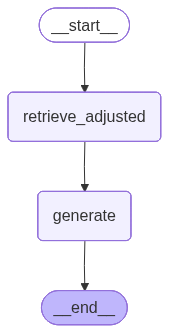

In [35]:
from IPython.display import Image, display
display(Image(adjusted_graph.get_graph().draw_mermaid_png()))

Let's verify the improved pipeline works:

In [31]:
response = adjusted_graph.invoke({"question": "How does Stone Ridge approach risk management in their energy investments?"})
response["response"]

'The provided context does not specify the specific methods or strategies Stone Ridge uses to approach risk management in their energy investments. It mentions that Stone Ridge Energy (SRE) has purchased a substantial amount of energy assets through proprietary securitizations, emphasizing a structure that avoids bankers, information leakage, and fee leakage. The context also highlights their experience with volatile natural gas prices but does not detail particular risk management techniques.'

### Running the Improved Evaluation

Now let's run the same synthetic test set through our improved pipeline and compare.

In [33]:
import time
import copy

rerank_testset = copy.deepcopy(testset)

for test_row in rerank_testset:
    response = adjusted_graph.invoke({"question": test_row.eval_sample.user_input})
    test_row.eval_sample.response = response["response"]
    test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
    time.sleep(2)  # To avoid rate limiting

In [34]:
rerank_evaluation_dataset = EvaluationDataset.from_pandas(rerank_testset.to_pandas())

rerank_result = evaluate(
    dataset=rerank_evaluation_dataset,
    metrics=[
        LLMContextRecall(),
        Faithfulness(),
        FactualCorrectness(),
        ResponseRelevancy(),
        ContextEntityRecall(),
        NoiseSensitivity(),
    ],
    llm=evaluator_llm,
    run_config=custom_run_config,
)
rerank_result

# previous metrics
# {'context_recall': 0.0833, 'faithfulness': 0.4631, 'factual_correctness': 0.3767, 'answer_relevancy': 0.5616, 'context_entity_recall': 0.2324, 'noise_sensitivity_relevant': 0.0234}

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

{'context_recall': 0.4833, 'faithfulness': 0.7290, 'factual_correctness': 0.4680, 'answer_relevancy': 0.8495, 'context_entity_recall': 0.3697, 'noise_sensitivity_relevant': 0.2852}

### ❓ Question #4:

Which system performed better, on what metrics, and why?

##### ✅ Answer:

The seconc, adjusted, system worked better, as graded by every metric except 'noise_sensitivity_relevant': context_recall, faithfulness, factual_corectness, answer_relevancy, context_entity_recall
The system with a larger, more dense, corpus of document data beceoms more sensitive to noisy or irrelevant documents. 
<br><br>
The second system used larger chunks of text for embeddring model inputs, allowing more complex and denser facts to be extracted. It used more documents in total for its search speace, and then also selected the top 5 most relevant documents from that space for similarity comparison. 

### ❓ Question #5:

What are the benefits and limitations of using synthetic data generation for RAG evaluation? Consider both the practical advantages and potential pitfalls.

##### ✅ Answer:

Benefits: faster to generate, less tedious manual input, can cover a broad set of potential use cases
<br><br>
Limitations: synthetic questions are only as "creative" as the underlying model allows them to be, they may miss first-order and second-order connections that humans may instictively know and assume the RAG system to know as well

### ❓ Question #6:

If you were building a production investment advisory assistant for Stone Ridge, which Ragas metrics would be most important to optimize for and why? Consider the financial services domain specifically.

##### ✅ Answer:
For a production investment assistant every metric listed above would be relevant. You want your answers to be always be correct and as faithful as possible when large amounts of money and client trust are at stake. You would also want low sensitivity to document noise, as much of the data in the financial world is noisy, dirty and full of irrelevant dimensions. 

### 🏗️ Activity #2: Implement a Different Reranking Strategy

Experiment with different reranking parameters or strategies to see how they affect the evaluation metrics.

**Requirements:**
1. Modify the `retrieve_adjusted` function to use different parameters (e.g., change `k` values, try different `top_n` for reranking)
2. Or implement a different retrieval enhancement strategy (e.g., hybrid search, query expansion)
3. Run the evaluation and compare results with the baseline and reranking results above
4. Document your findings in the markdown cell below

In [38]:
### YOUR CODE HERE ###

# Implement your custom retrieval strategy here
# Example: modify retrieve_adjusted with different parameters

def retrieve_custom(state):
    compressor = CohereRerank(model="rerank-v3.5")
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=compressor,
        base_retriever=adjusted_retriever,
        search_kwargs={"k": 10},
    )
    retrieved_docs = compression_retriever.invoke(state["question"])
    return {"context": retrieved_docs}

class CustomGraphState(TypedDict):
    question: str
    context: List[Document]
    response: str

custom_graph_builder = StateGraph(CustomGraphState).add_sequence([retrieve_custom, generate])
custom_graph_builder.add_edge(START, "retrieve_custom")
custom_graph = custom_graph_builder.compile()

rerank_testset = copy.deepcopy(testset)

for test_row in rerank_testset:
    response = custom_graph.invoke({"question": test_row.eval_sample.user_input})
    test_row.eval_sample.response = response["response"]
    test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
    time.sleep(2)  # To avoid rate limiting

rerank_evaluation_dataset = EvaluationDataset.from_pandas(rerank_testset.to_pandas())

rerank_result = evaluate(
    dataset=rerank_evaluation_dataset,
    metrics=[
        LLMContextRecall(),
        Faithfulness(),
        FactualCorrectness(),
        ResponseRelevancy(),
        ContextEntityRecall(),
        NoiseSensitivity(),
    ],
    llm=evaluator_llm,
    run_config=custom_run_config,
)
rerank_result

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[8]: AttributeError('StringIO' object has no attribute 'statements')
Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x10c0da380> is already entered
Exception raised in Job[11]: AttributeError('StringIO' object has no attribute 'statements')
Task was destroyed but it is pending!
task: <Task pending name='Task-4529' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/alexei.naumann/Desktop/AIE/AI-Engineering/07_Synthetic_Data_and_Evaluation/.venv/lib/python3.13/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-4530' coro=<Kernel.shell_main() running at /Users/ale

{'context_recall': 0.5083, 'faithfulness': 0.7086, 'factual_correctness': 0.5178, 'answer_relevancy': 0.8502, 'context_entity_recall': 0.3747, 'noise_sensitivity_relevant': 0.2461}

In [ ]:
# previous metrics
# {'context_recall': 0.0833, 'faithfulness': 0.4631, 'factual_correctness': 0.3767, 'answer_relevancy': 0.5616, 'context_entity_recall': 0.2324, 'noise_sensitivity_relevant': 0.0234}

# Adjusted Results
# {'context_recall': 0.4833, 'faithfulness': 0.7290, 'factual_correctness': 0.4680, 'answer_relevancy': 0.8495, 'context_entity_recall': 0.3697, 'noise_sensitivity_relevant': 0.2852}

# Custom metrics
# {'context_recall': 0.5083, 'faithfulness': 0.7086, 'factual_correctness': 0.5178, 'answer_relevancy': 0.8502, 'context_entity_recall': 0.3747, 'noise_sensitivity_relevant': 0.2461}

### Activity #2 Findings:

| Metric | Previous | Adjusted | Custom |
|---|---|---|---|
| context_recall | 0.0833 | 0.4833 | 0.5083 |
| faithfulness | 0.4631 | 0.7290 | 0.7086 |
| factual_correctness | 0.3767 | 0.4680 | 0.5178 |
| answer_relevancy | 0.5616 | 0.8495 | 0.8502 |
| context_entity_recall | 0.2324 | 0.3697 | 0.3747 |
| noise_sensitivity_relevant | 0.0234 | 0.2852 | 0.2461 |

For the custom retriever, I simnply increaed the number of documents that were passed to Cohere for reranking. Increasing this value from 5 to 10 improved the system's context recall, factual_corectness, answer relevancy, context entity recall. Changing that value also decreased the faithfulness metric and gave a higher noise sensitivity vale than the base models. This means it was more likely to halucinate data and be sensitive to document noise. 

---
## Summary

In this notebook, we went end-to-end from data generation to evaluation:

1. **Built a knowledge graph** from our investment documents (Stone Ridge 2025 Investor Letter and Alternative Investments Handbook) and used it to understand the structure of our data
2. **Generated synthetic test data** with diverse query types (single-hop, multi-hop abstract, multi-hop specific)
3. **Built a baseline RAG pipeline** with deliberately simple parameters
4. **Evaluated with Ragas** across six metrics to establish a baseline
5. **Improved the pipeline** with larger chunks and Cohere reranking
6. **Re-evaluated** to measure the impact of our changes

### Key Takeaways:

- **Synthetic data generation** is critical for early iteration — it provides high-quality signal without manually creating test data
- **Ragas metrics** give you a multi-dimensional view of RAG quality (retrieval vs. generation vs. faithfulness)
- **Small changes matter** — chunk size, retrieval strategy, and reranking can dramatically affect evaluation scores
- **Always use a different model for judging** than for generating to avoid self-evaluation bias